In [2]:
import numpy as np
import pandas as pd
import pylab
import random,math
import matplotlib.pyplot as plt

In [3]:
datas = pd.read_csv("faithful.txt",sep=' ',header=None)
datas.shape

(272, 2)

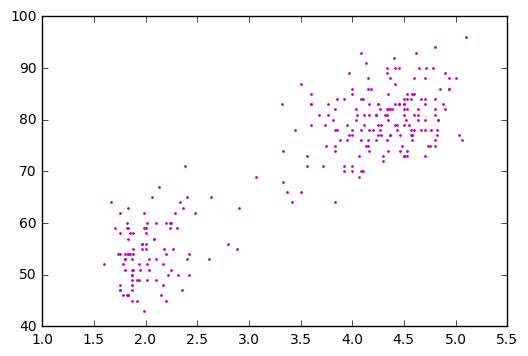

In [4]:
x,y = datas[0],datas[1]
plt.scatter(x,y, color = 'm', label='1', s = 1)  
plt.show()

In [5]:
def loadDataSet(fileName):      #general function to parse tab -delimited floats
    dataMat = []                #assume last column is target value
    fr = open(fileName)
    for line in fr.readlines():
        curLine = line.strip().split(' ')
        fltLine = map(float,curLine) #map all elements to float()
        dataMat.append(fltLine)
    return dataMat

In [4]:
# datas = loadDataSet("faithful.txt")
# datas

In [6]:
def init_params(X,centroids,K,N,D):  
    pMiu = centroids #k*D, 即k类的中心点  
    pPi = zeros([1, K]) #k类GMM所占权重（influence factor）  
    pSigma = zeros([D, D, K]) #k类GMM的协方差矩阵，每个是D*D的  

    # 距离矩阵，计算N*K的矩阵（x-pMiu）^2 = x^2+pMiu^2-2*x*Miu  
    #x^2, N*1的矩阵replicateK列\#pMiu^2，1*K的矩阵replicateN行
    distmat = tile(sum(power(X,2), 1),(1, K)) + \
        tile(transpose(sum(power(pMiu,2), 1)),(N, 1)) -  \
        2*X*transpose(pMiu)
    labels = distmat.argmin(1) #Return the minimum from each row  

    # 获取k类的pPi和协方差矩阵
    for k in range(K):
        boolList = (labels==k).tolist()
        indexList = [boolList.index(i) for i in boolList if i==[True]]
        Xk = X[indexList, :]
        #print cov(Xk)
        # 也可以用shape(XK)[0]
        pPi[0][k] = float(size(Xk, 0))/N
        pSigma[:, :, k] = cov(transpose(Xk))  

    return pMiu,pPi,pSigma

In [7]:
# 计算每个数据由第k类生成的概率矩阵Px
# 计算后验概率

def calc_prob(pMiu,pSigma,X,K,N,D):
    # Gaussian posterior probability   
    # N(x|pMiu,pSigma) = 1/((2pi)^(D/2))*(1/(abs(sigma))^0.5)*exp(-1/2*(x-pMiu)'pSigma^(-1)*(x-pMiu))  
    Px = mat(zeros([N, K]))
    for k in range(K):
        Xshift = X-tile(pMiu[k, :],(N, 1)) #X-pMiu  
        #inv_pSigma = mat(pSigma[:, :, k]).I
        inv_pSigma = linalg.pinv(mat(pSigma[:, :, k]))

        tmp = sum(array((Xshift*inv_pSigma)) * array(Xshift), 1) # 这里应变为一列数
        tmp = mat(tmp).T
        print tmp
        #print linalg.det(inv_pSigma),'54545'

        Sigema = linalg.det(mat(inv_pSigma))

        if Sigema < 0:
            Sigema=0

        coef = power((2*(math.pi)),(-D/2)) * sqrt(Sigema)              
        Px[:, k] = coef * exp(-0.5*tmp)          
    return Px

In [8]:
######################################################
#     - X: N-by-D data matrix.  
#     - K_OR_CENTROIDS: either K indicating the number of  
#        components or a K-by-D matrix indicating the  
#        choosing of the initial K centroids.  
  
#     - PX: N-by-K matrix indicating the probability of each   
#        component generating each point.  
#     - MODEL: a structure containing the parameters for a GMM:  
#         MODEL.Miu: a K-by-D matrix.  
#         MODEL.Sigma: a D-by-D-by-K matrix.  
#         MODEL.Pi: a 1-by-K vector.
######################################################
# def gmm(file, K_or_centroids):
 
K_or_centroids = 2
#     Generate Initial Centroids  
threshold = 1e-15
dataMat = mat(loadDataSet("faithful.txt"))
# dataMat = datas
[N, D] = shape(dataMat)
print "shape is:",(N,D)
#     K_or_centroids = 2
# K_or_centroids可以是一个整数，也可以是k个质心的二维列向量
if shape(K_or_centroids)==(): #if K_or_centroid is a 1*1 number  整数
    K = K_or_centroids
    Rn_index = range(N)
    random.shuffle(Rn_index) #random index N samples  
    centroids = dataMat[Rn_index[0:K], :]; #generate K random centroid  
    print K,"heheehe"
else: # K_or_centroid is a initial K centroid  
    K = size(K_or_centroids)[0];   
    centroids = K_or_centroids;  


## initial values  
[pMiu,pPi,pSigma] = init_params(dataMat,centroids,K,N,D)  

Lprev = -inf #上一次聚类的误差 



# EM Algorithm  
while True:
    # Estimation Step  
    Px = calc_prob(pMiu,pSigma,dataMat,K,N,D)
    print "pMiu:",pMiu, "pSigma:",pSigma,"dataMat:",dataMat,"K:",K
    # new value for pGamma(N*k), pGamma(i,k) = Xi由第k个Gaussian生成的概率  
    # 或者说xi中有pGamma(i,k)是由第k个Gaussian生成的  
    pGamma = mat(array(Px) * array(tile(pPi, (N, 1))))  #分子 = pi(k) * N(xi | pMiu(k), pSigma(k))  
    pGamma = pGamma / tile(sum(pGamma, 1), (1, K)) #分母 = pi(j) * N(xi | pMiu(j), pSigma(j))对所有j求和  

    ## Maximization Step - through Maximize likelihood Estimation  
    #print 'dtypeddddddddd:',pGamma.dtype
    Nk = sum(pGamma, 0) #Nk(1*k) = 第k个高斯生成每个样本的概率的和，所有Nk的总和为N。  

    # update pMiu  
    pMiu = mat(diag((1/Nk).tolist()[0])) * (pGamma.T) * dataMat #update pMiu through MLE(通过令导数 = 0得到)  
    pPi = Nk/N

    # update k个 pSigma  
    print 'kk=',K
    for kk in range(K):
        Xshift = dataMat-tile(pMiu[kk], (N, 1))  

#             print Xshift.T * mat(diag(pGamma[:, kk].T.tolist()[0])) *  Xshift /  Nk[kk]

#             pSigma[:, :, kk] = (Xshift.T * mat(diag(pGamma[:, kk].T.tolist()[0])) * Xshift) / Nk[kk]

    # check for convergence  
#         L = sum(log(Px*(pPi.T)))  
#         if L-Lprev < threshold:
    break        
#         Lprev = L

# return Px   

NameError: name 'mat' is not defined

In [9]:
Rn_index[0:2]

NameError: name 'Rn_index' is not defined

In [10]:
dataMat[Rn_index[0:2],:]

NameError: name 'dataMat' is not defined

In [25]:
pGamma

matrix([[ nan,  nan],
        [ nan,  nan],
        [ nan,  nan],
        [ nan,  nan],
        [ nan,  nan],
        [ nan,  nan],
        [ nan,  nan],
        [ nan,  nan],
        [ nan,  nan],
        [ nan,  nan],
        [ nan,  nan],
        [ nan,  nan],
        [ nan,  nan],
        [ nan,  nan],
        [ nan,  nan],
        [ nan,  nan],
        [ nan,  nan],
        [ nan,  nan],
        [ nan,  nan],
        [ nan,  nan],
        [ nan,  nan],
        [ nan,  nan],
        [ nan,  nan],
        [ nan,  nan],
        [ nan,  nan],
        [ nan,  nan],
        [ nan,  nan],
        [ nan,  nan],
        [ nan,  nan],
        [ nan,  nan],
        [ nan,  nan],
        [ nan,  nan],
        [ nan,  nan],
        [ nan,  nan],
        [ nan,  nan],
        [ nan,  nan],
        [ nan,  nan],
        [ nan,  nan],
        [ nan,  nan],
        [ nan,  nan],
        [ nan,  nan],
        [ nan,  nan],
        [ nan,  nan],
        [ nan,  nan],
        [ nan,  nan],
        [ 

In [ ]:
####http://blog.csdn.net/golden1314521/article/details/46051431

In [17]:
# 计算概率密度，
# 参数皆为array类型，过程中参数不变
def gaussian(x,mean,cov):

    dim = np.shape(cov)[0] #维度
    #之所以加入单位矩阵是为了防止行列式为0的情况
    covdet = np.linalg.det(cov+np.eye(dim)*0.01) #协方差矩阵的行列式
    covinv = np.linalg.inv(cov+np.eye(dim)*0.01) #协方差矩阵的逆
    xdiff = x - mean
    #概率密度
    prob = 1.0/np.power(2*np.pi,1.0*dim/2)/np.sqrt(np.abs(covdet))*np.exp(-1.0/2*np.dot(np.dot(xdiff,covinv),xdiff))
    return prob


#获取初始协方差矩阵
def getconvs(data,K):
    convs = [0]*K
    for i in range(K):
        # 初始的协方差矩阵源自于原始数据的协方差矩阵，且每个簇的初始协方差矩阵相同
        convs[i] = np.cov(data.T)  
    return convs


def isdistinct(means,criter=0.03): #检测初始中心点是否靠得过近
    K = len(means)
    for i in range(K):
        for j in range(i+1,K):
            if criter > np.linalg.norm(means[i]-means[j]):
                return 0       
    return True
#获取初始聚簇中心
def getmeans(data,K,criter):
    means = [0]*K
    dim  = np.shape(data)[1]
    minmax = [] #各个维度的极大极小值
    for i in range(dim):
        minmax.append(np.array([min(data[:,i]),max(data[:,i])]))

    while True:
        #生成初始点的坐标
        for i in range(K):
            means[i] = []
            for j in range(dim):
                means[i].append(np.random.random()*(minmax[j][1]-minmax[j][0])+minmax[j][0])  
            means[i] = np.array(means[i])

        if isdistinct(means,criter):
            break  
    return means

# k-means算法的实现函数。
#用K-means算法输出的聚类中心，作为高斯混合模型的输入
def kmeans(data,K):
    N = np.shape(data)[0]#样本数目
    dim = np.shape(data)[1] #维度

    means = getmeans(data,K,criter=15)
    means_old = [np.zeros(dim) for k in range(K)]


    while np.sum([np.linalg.norm(means_old[k]-means[k]) for k in range(K)]) > 0.01:

        means_old = cp.deepcopy(means)

        numlog = [0]*K
        sumlog = [np.zeros(dim) for k in range(K)]
        for n in range(N):
            distlog = [np.linalg.norm(data[n]-means[k]) for k in range(K)]
            toK = distlog.index(np.min(distlog))

            numlog[toK] += 1
            sumlog[toK] += data[n]

        for k in range(K):
            means[k] = 1.0/numlog[k]*sumlog[k]
    return means

#对程序结果进行可视化，注意这里的K只能取2，否则该函数运行出错
def visualresult(data,gammas,K):
    plt.figure(figsize=(20,12))
    N = np.shape(data)[0]#样本数目
    dim = np.shape(data)[1] #维度

    minmax = [] #各个维度的极大极小值
    xy = []
    n=200
    for i in range(dim):
        delta = 0.05*(np.max(data[:,i])-np.min(data[:,i]))
        xy.append(np.linspace(np.min(data[:,i])-delta,np.max(data[:,i])+delta,n))
    xx,yy = np.meshgrid(xy[0], xy[1])
    zz = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            zz[i][j] = np.sum(gaussian(np.array([xx[i][j],yy[i][j]]),means[k],convs[k]) for k in range(K))
    #显示热力图
    #gci = plt.imshow(zz,origin='lower',alpha = 0.8) # 选项origin='lower' 防止图像颠倒
    #plt.xticks([0,len(xy[0])-1],[xy[0][0],xy[0][-1]])
    #plt.yticks([0,len(xy[1])-1],[xy[1][0],xy[1][-1]])

    for i in range(N):
        if gammas[i][0] >0.5:
            plt.plot((data[i][0]-np.min(data[:,0]))/(xy[0][1]-xy[0][0]),(data[i][1]-np.min(data[:,1]))/(xy[1][1]-xy[1][0]),'r.')
        else:
            plt.plot((data[i][0]-np.min(data[:,0]))/(xy[0][1]-xy[0][0]),(data[i][1]-np.min(data[:,1]))/(xy[1][1]-xy[1][0]),'k.')

    deltax = xy[0][1]-xy[0][0]
    deltay = xy[1][1]-xy[1][0]

    plt.plot((means[0][0]-xy[0][0])/deltax,(means[0][1]-xy[1][0])/deltay,'*r',markersize=15)
    plt.plot((means[1][0]-xy[0][0])/deltax,(means[1][1]-xy[1][0])/deltay,'*k',markersize=15)

    plt.title(u'GMM')
    plt.show()

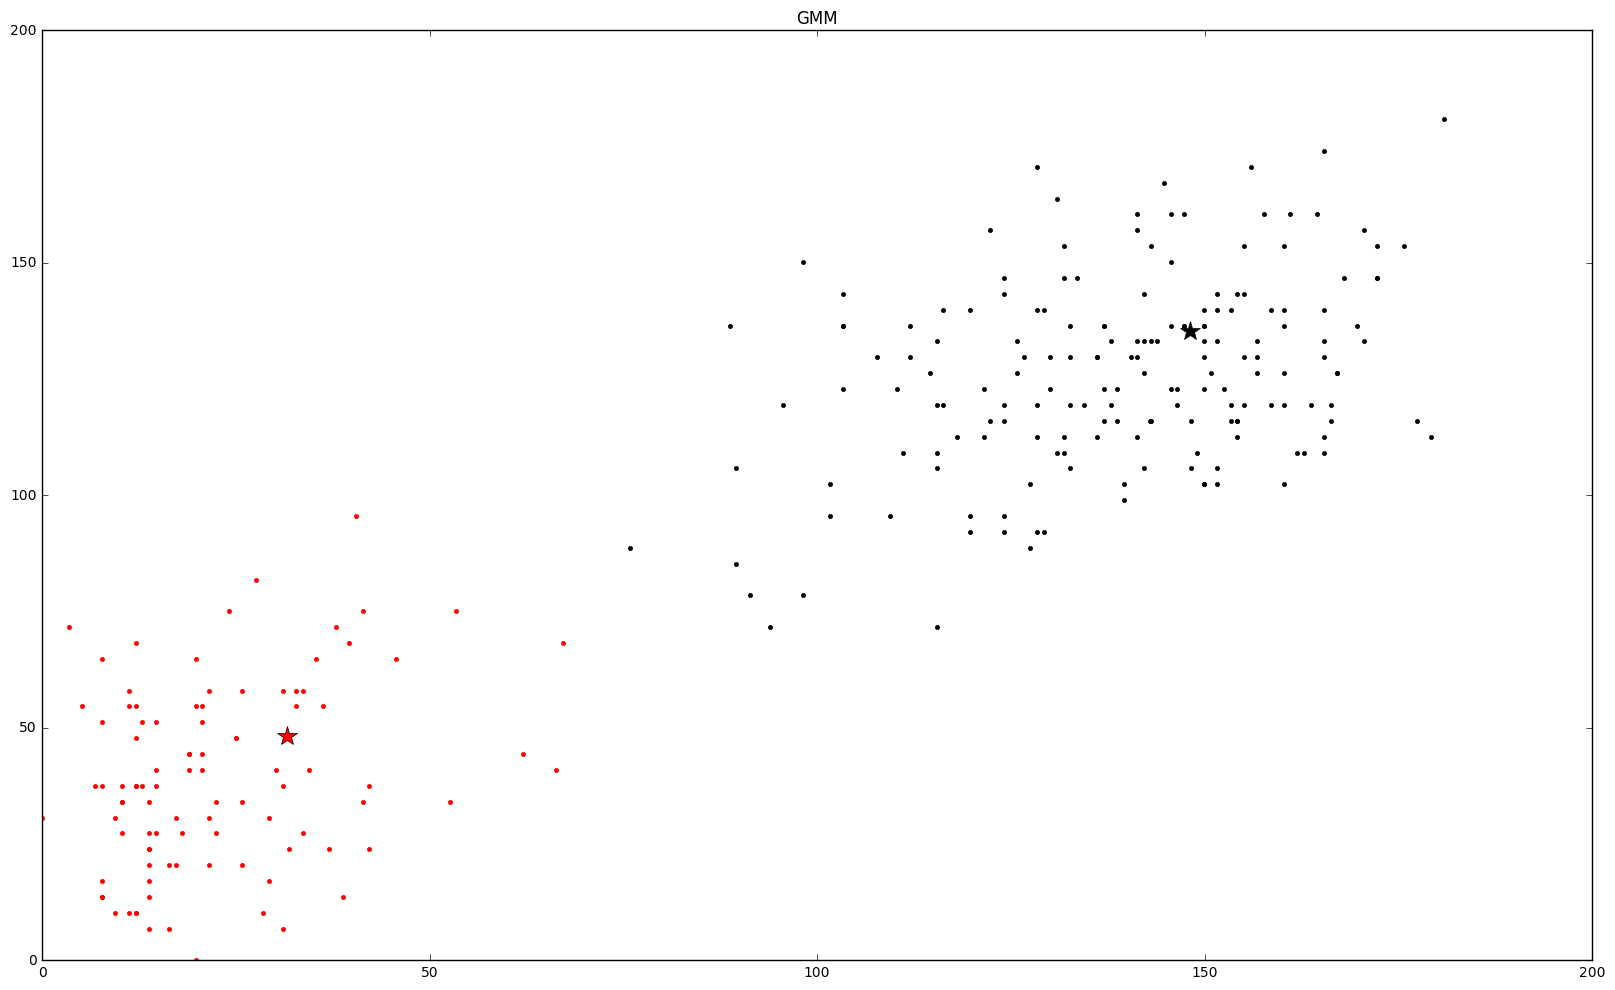

In [18]:
import copy as cp
data = loadDataSet("faithful.txt")
data = np.array(data)
N = np.shape(data)[0]#样本数目
dim = np.shape(data)[1] #维度
K = 2 # 聚簇的个数

means = kmeans(data,K)

convs = getconvs(data,K)

pis = [1.0/K]*K
gammas = [np.zeros(K) for i in range(N)] #*N 注意不能用 *N，否则N个array只指向一个地址

loglikelyhood = 0
oldloglikelyhood = 1

while np.abs(loglikelyhood - oldloglikelyhood)> 0.0001:
    oldloglikelyhood = loglikelyhood


    # E_step
    for n in range(N):
        respons = [pis[k]*gaussian(data[n],means[k],convs[k]) for k in range(K)]

        sumrespons = np.sum(respons)
        for k in range(K):
            gammas[n][k] = respons[k]/sumrespons

    # M_step
    for k in range(K):
        nk = np.sum([gammas[n][k] for n in range(N)])
        means[k] = 1.0/nk * np.sum([gammas[n][k]*data[n] for n in range(N)],axis=0)

        xdiffs = data - means[k]
        convs[k] = 1.0/nk * np.sum([gammas[n][k]*xdiffs[n].reshape(dim,1)*xdiffs[n] for n in range(N)],axis=0)
        pis[k] = 1.0*nk/N

    # 计算似然函数值
    loglikelyhood =np.sum( [np.log(np.sum([pis[k]*gaussian(data[n],means[k],convs[k]) for k in range(K)])) for n in range(N) ])
    #print means
    #print loglikelyhood
    #print '=='*10

visualresult(data,gammas,K)